Total false negatives found: 161

Top 10 not acquired artworks with highest predicted probability:


,year,material,medium,classification,country,era,department,y_proba
164811,1950.0,Unknown,Unknown,Mies van der Rohe Archive,USA,Contemporary,Architecture & Design,0.494609
79622,1871.0,Unknown,Unknown,Photograph,USA,Modern,Photography,0.490000
110884,1928.0,Other,Tempera on poster board,Painting,USA,Modern,Film,0.487175
168511,1957.0,Ink,Ink on paper,Mies van der Rohe Archive,USA,Contemporary,Architecture & Design,0.477417
52368,1870.0,Unknown,Unknown,Photograph,Other,Modern,Photography,0.470000
169840,1960.0,Other,Pencil on acetate,Mies van der Rohe Archive,USA,Contemporary,Architecture & Design,0.466922
169815,1960.0,Other,Pencil on acetate,Mies van der Rohe Archive,USA,Contemporary,Architecture & Design,0.466922
170101,1960.0,Other,Pencil on acetate,Mies van der Rohe Archive,USA,Contemporary,Architecture & Design,0.466922
169807,1960.0,Other,Pencil on acetate,Mies van der Rohe Archive,USA,Contemporary,Architecture & Design,0.466922
169859,1960.0,Other,Pencil on acetate,Mies van der Rohe Archive,USA,Contemporary,Architecture & Design,0.466922


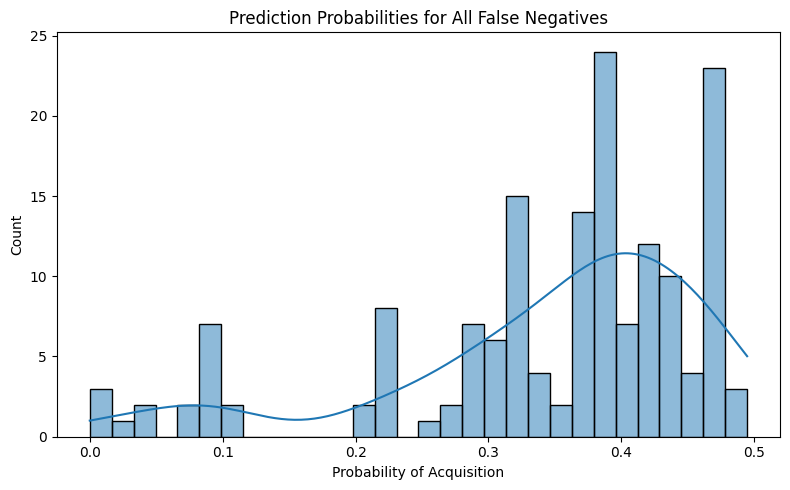

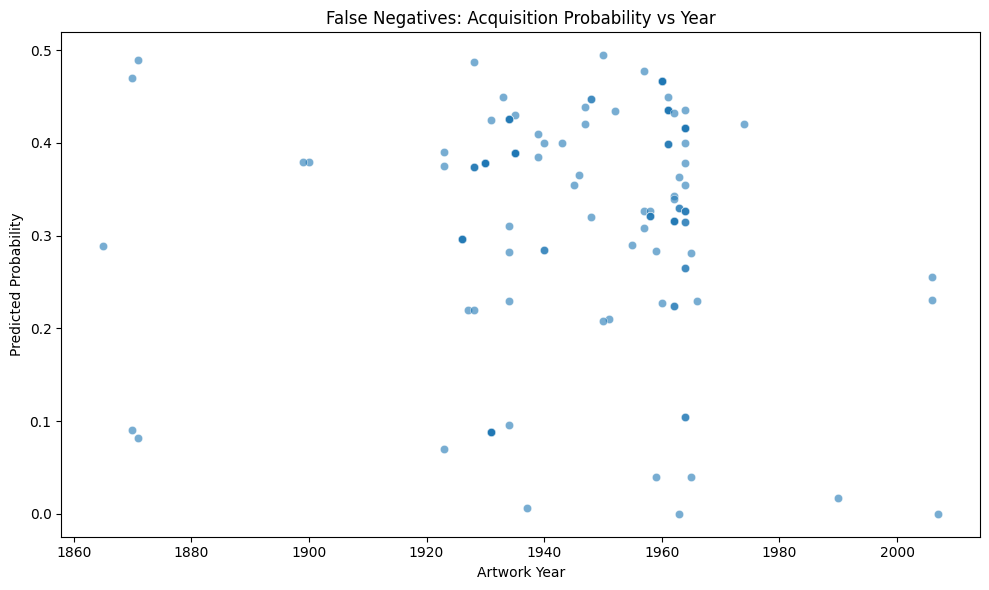

In [5]:
# 09_high_value_not_acquired.ipynb

import sys
import os
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# Set path for imports
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
import src.data_loader as dl

# --- Load data ---
X_test = joblib.load("../outputs/X_test.pkl")
y_test = joblib.load("../outputs/y_test.pkl")
y_pred = joblib.load("../outputs/y_pred.pkl")
X_test_raw = joblib.load("../outputs/X_test_raw.pkl")

# --- Combine into one DataFrame ---
results = X_test_raw.copy()
results["y_true"] = y_test
results["y_pred"] = y_pred

# --- Add prediction probabilities ---
model = joblib.load("../outputs/classifier_pipeline.pkl")
probas = model.predict_proba(X_test)[:, 1]
results["y_proba"] = probas

# --- Identify false negatives ---
results["error_type"] = "TN"
results.loc[(results.y_true == 1) & (results.y_pred == 0), "error_type"] = "FN"
results.loc[(results.y_true == 0) & (results.y_pred == 1), "error_type"] = "FP"
results.loc[(results.y_true == 1) & (results.y_pred == 1), "error_type"] = "TP"

# Extract all false negatives (no threshold)
false_negatives = results[results.error_type == "FN"]
false_negatives_sorted = false_negatives.sort_values(by="y_proba", ascending=False)

print(f"Total false negatives found: {len(false_negatives_sorted)}")

# --- Export to CSV for manual inspection ---
false_negatives_sorted.to_csv("../outputs/false_negatives_all.csv", index=False)

# --- Optional: Display top 10 ---
display_cols = ["year", "material", "medium", "classification", "country", "era", "department", "y_proba"]
print("\nTop 10 not acquired artworks with highest predicted probability:")
display(false_negatives_sorted[display_cols].head(10))

# --- Visualization: Prediction Probabilities for False Negatives ---
if not false_negatives.empty:
    plt.figure(figsize=(8, 5))
    sns.histplot(false_negatives["y_proba"], bins=30, kde=True)
    plt.title("Prediction Probabilities for All False Negatives")
    plt.xlabel("Probability of Acquisition")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

    # Extra: year vs probability scatter
    if "year" in false_negatives.columns:
        plt.figure(figsize=(10, 6))
        sns.scatterplot(data=false_negatives_sorted, x="year", y="y_proba", alpha=0.6)
        plt.title("False Negatives: Acquisition Probability vs Year")
        plt.xlabel("Artwork Year")
        plt.ylabel("Predicted Probability")
        plt.tight_layout()
        plt.show()
else:
    print("\nNo false negatives found in the dataset.")
